In [1]:
import os
import shutil
from pathlib import Path

import cv2
from PIL import Image, ImageOps
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

train_folder = "data/2/chest_xray/train"
test_folder = "data/2/chest_xray/test"
img_size = 200
train_output_folder = "data/processed/train"
test_output_folder = "data/processed/test"

2025-05-22 12:05:16.823509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 12:05:16.833108: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:05:16.835854: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:05:16.841921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747908316.852992   13019 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747908316.85

In [ ]:
# Download latest version of dataset and store it locally
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

target_dir = "data"
os.makedirs(target_dir, exist_ok=True)
shutil.move(path, target_dir)

📸 Images aux valeurs extrêmes :
                                               filename width height  \
1234  data/2/chest_xray/train\NORMAL\NORMAL2-IM-1257...  2916   2583   
1030  data/2/chest_xray/train\NORMAL\NORMAL2-IM-0994...  2373   2663   
1606  data/2/chest_xray/train\PNEUMONIA\person1147_v...  1624   1944   
3353  data/2/chest_xray/train\PNEUMONIA\person325_vi...   446    132   
3682  data/2/chest_xray/train\PNEUMONIA\person407_vi...   384    127   

     aspect_ratio mode  error  
1234         1.13    L  False  
1030         0.89    L  False  
1606         0.84    L  False  
3353         3.38  RGB  False  
3682         3.02  RGB  False  


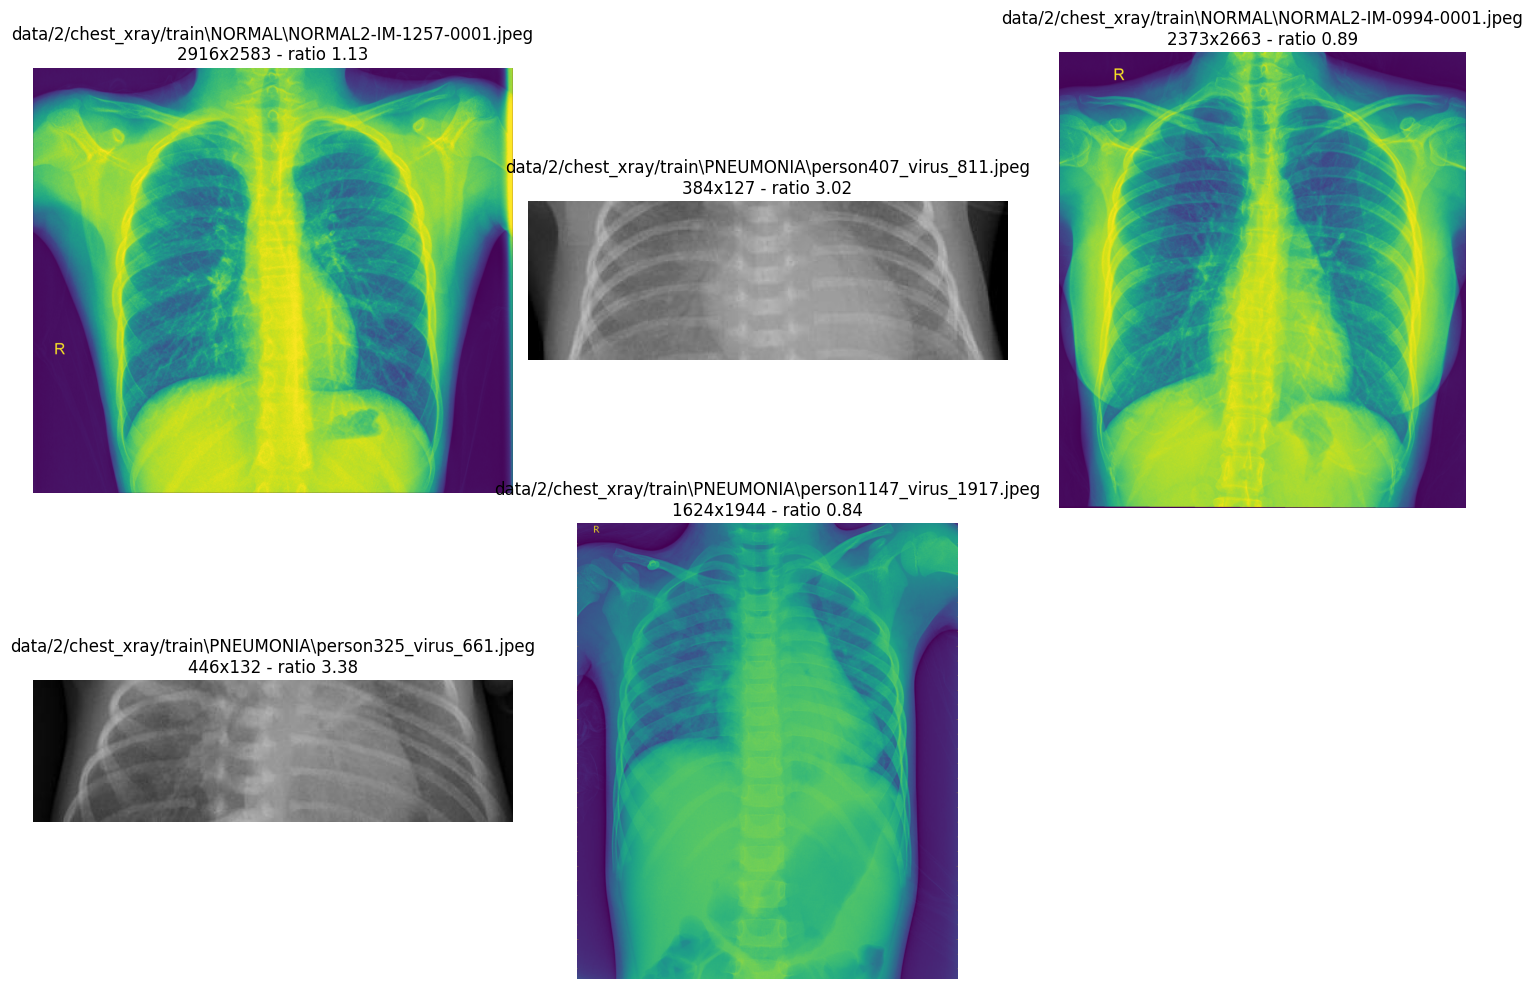

                                           filename  width  height  \
0  data/2/chest_xray/train\NORMAL\IM-0115-0001.jpeg   2090    1858   
1  data/2/chest_xray/train\NORMAL\IM-0117-0001.jpeg   1422    1152   
2  data/2/chest_xray/train\NORMAL\IM-0119-0001.jpeg   1810    1434   
3  data/2/chest_xray/train\NORMAL\IM-0122-0001.jpeg   1618    1279   
4  data/2/chest_xray/train\NORMAL\IM-0125-0001.jpeg   1600    1125   

   aspect_ratio mode  error  
0          1.12    L  False  
1          1.23    L  False  
2          1.26    L  False  
3          1.27    L  False  
4          1.42    L  False  
             width       height  aspect_ratio
count  5216.000000  5216.000000   5216.000000
mean   1320.610813   968.074770      1.440234
std     355.298743   378.855691      0.257314
min     384.000000   127.000000      0.840000
25%    1056.000000   688.000000      1.260000
50%    1284.000000   888.000000      1.410000
75%    1552.000000  1187.750000      1.580000
max    2916.000000  2663.000000

In [ ]:
# Analyser les images
def get_image_info(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return {
                "filename": file_path,
                "width": width,
                "height": height,
                "aspect_ratio": round(width / height, 2),
                "mode": img.mode,
                "error": False
            }
    except Exception as e:
        return {
            "error": str(e)
        }
    
def get_images_info(folder_path):
    
    images_info = []

    for label in sorted(os.listdir(folder_path)):

        if not label in ("NORMAL", "PNEUMONIA"):
            continue
        label_path = os.path.join(folder_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            info = get_image_info(file_path)
            images_info.append(info)

    df = pd.DataFrame(images_info)
    return df

def show_images(df_extremes, folder_path, ncols=3):
    folder = Path(folder_path)
    n = len(df_extremes)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for idx, row in df_extremes.iterrows():
        img_path = Path(row["filename"])
        with Image.open(img_path) as img:
            axes[idx].imshow(img)
            axes[idx].set_title(f'{row["filename"]}\n{row["width"]}x{row["height"]} - ratio {row["aspect_ratio"]}')
            axes[idx].axis('off')

    # Cacher les cases vides si besoin
    for i in range(len(df_extremes), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()    

df_train_images = get_images_info(train_folder)
df_train_valid = df_train_images[df_train_images["error"] == False]

# Identifier les images extrêmes
extremes = pd.concat([
    df_train_valid.loc[df_train_valid["width"].idxmax()],
    df_train_valid.loc[df_train_valid["width"].idxmin()],
    df_train_valid.loc[df_train_valid["height"].idxmax()],
    df_train_valid.loc[df_train_valid["height"].idxmin()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmax()],
    df_train_valid.loc[df_train_valid["aspect_ratio"].idxmin()],
], axis=1).T.drop_duplicates()

# Affichage en tableau
print("📸 Images aux valeurs extrêmes :")
print(extremes.sort_values(by=["width", "height"], ascending=[False, False]))

# Affichage des images extrêmes
show_images(extremes.reset_index(drop=True), folder_path=train_folder)

# Aperçu
print(df_train_images.head())
# Statistiques
print(df_train_images.describe())


In [40]:
def square_image(image:Image):
    width, height = image.size
    size = max(width, height)

    border_w = size - width
    border_h = size - height

    padding = (
        border_w // 2,
        border_h // 2,
        border_w - (border_w // 2),
        border_h - (border_h // 2),
    )

    squared_img = ImageOps.expand(image, padding, fill="black")
    
    return squared_img

def prepare_data(input_folder:str, output_folder:str):
    """    
    passer toutes les images en nuances de gris
    Ajouter des bandes noires pour rendre toutes les images carrées
    redimensionner toutes les images
    """
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    for file_path in input_folder.rglob("*"):
        if file_path.is_file():
            try:
                with Image.open(file_path) as img:
                    # Convert to grayscale
                    img = img.convert("L")
                    # Add black borders to square image
                    img = square_image(img)
                    # Resize image
                    img = img.resize((img_size, img_size), resample=Image.BILINEAR)

                    # Save image
                    rel_path = file_path.relative_to(input_folder)
                    output_path = output_folder / rel_path
                    output_path.parent.mkdir(parents=True, exist_ok=True)
                    output_path = output_path.with_suffix(".jpeg")

                    img.save(output_path)

            except Exception as e:
                print(f"❌ Error processing {file_path.name}: {e}")

prepare_data(train_folder, train_output_folder)
prepare_data(test_folder, test_output_folder)

In [2]:
# Préparation des données
def get_train_test(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if not label in ("NORMAL", "PNEUMONIA"):
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # image illisible, on passe
            X.append(img)           # on ajoute l'image à la liste
            y.append(1 if label == "PNEUMONIA" else 0)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_test("data/processed/train")
X_test, y_test = get_train_test("data/processed/test")


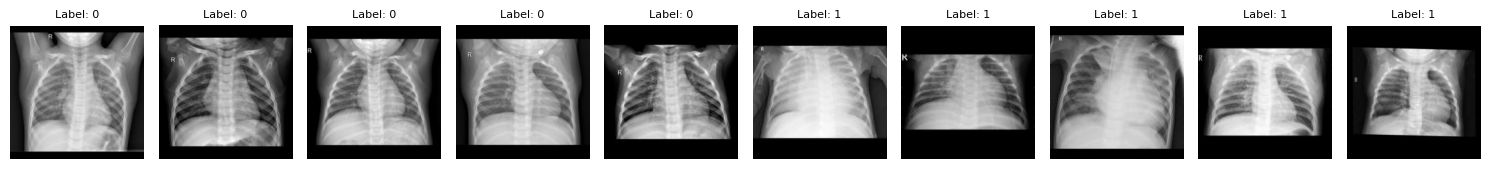

In [3]:
# Sélectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices sélectionnés
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

# On n'aplatit pas maintenant car les convolution ont besoin de matrices

In [ ]:
# Création du modèle
